In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import medpy
import skimage
import cv2
import scipy
import networkx as nx
import skimage

from scipy import sparse
from scipy.sparse import csgraph
from skimage.morphology._util import _raveled_offsets_and_distances
from skimage.util._map_array import map_array

In [278]:
def pixel_graph(
        image, *, mask=None, edge_function=None,
        max_g=None, weights_r=None, weights_u=None, ilm_image=None, connectivity=1, spacing=None
        ):
    """Create an adjacency graph of pixels in an image.
    Pixels where the mask is True are nodes in the returned graph, and they are
    connected by edges to their neighbors according to the connectivity
    parameter. By default, the *value* of an edge when a mask is given, or when
    the image is itself the mask, is the euclidean distance betwene the pixels.
    However, if an int- or float-valued image is given with no mask, the value
    of the edges is the absolute difference in intensity between adjacent
    pixels, weighted by the euclidean distance.
    Parameters
    ----------
    image : array
        The input image. If the image is of type bool, it will be used as the
        mask as well.
    mask : array of bool
        Which pixels to use. If None, the graph for the whole image is used.
    edge_function : callable
        A function taking an array of pixel values, and an array of neighbor
        pixel values, and an array of distances, and returning a value for the
        edge. If no function is given, the value of an edge is just the
        distance.
    connectivity : int
        The square connectivity of the pixel neighborhood: the number of
        orthogonal steps allowed to consider a pixel a neigbor. See
        `scipy.ndimage.generate_binary_structure` for details.
    spacing : tuple of float
        The spacing between pixels along each axis.
    Returns
    -------
    graph : scipy.sparse.csr_matrix
        A sparse adjacency matrix in which entry (i, j) is 1 if nodes i and j
        are neighbors, 0 otherwise.
    nodes : array of int
        The nodes of the graph. These correspond to the raveled indices of the
        nonzero pixels in the mask.
    """
    if image.dtype == bool and mask is None:
        mask = image
    if mask is None and edge_function is None:
        mask = np.ones_like(image, dtype=bool)
        edge_function = _weighted_abs_diff
    if mask is None and edge_function is not None:
        mask = np.ones_like(image, dtype=bool)

    padded = np.pad(mask, 1, mode='constant', constant_values=False)
    nodes_padded = np.flatnonzero(padded)
    neighbor_offsets_padded, distances_padded = _raveled_offsets_and_distances(
            padded.shape, connectivity=connectivity, spacing=spacing
            )
    neighbors_padded = nodes_padded[:, np.newaxis] + neighbor_offsets_padded
    neighbor_distances_full = np.broadcast_to(
            distances_padded, neighbors_padded.shape
            )
    nodes = np.flatnonzero(mask)
    nodes_sequential = np.arange(nodes.size)
    # neighbors outside the mask get mapped to 0, which is a valid index,
    # BUT, they will be masked out in the next step.
    
    neighbors = map_array(neighbors_padded, nodes_padded, nodes)
    neighbors_mask = padded.reshape(-1)[neighbors_padded]
    num_neighbors = np.sum(neighbors_mask, axis=1)
    indices = np.repeat(nodes, num_neighbors)
    indices_sequential = np.repeat(nodes_sequential, num_neighbors)
    neighbor_indices = neighbors[neighbors_mask]
    neighbor_distances = neighbor_distances_full[neighbors_mask]
    neighbor_indices_sequential = map_array(
            neighbor_indices, nodes, nodes_sequential
            )
    if edge_function is None:
        data = neighbor_distances
    else:
        image_r = image.reshape(-1)
        shape = image.shape
        weights_r_flat = weights_r.reshape(-1)
        try:
            weights_u_flat = weights_u.reshape(-1)
        except:
            weights_u_flat = weights_r_flat
        data = edge_function(
            image_r[indices], image_r[neighbor_indices], max_g, weights_r_flat[indices],
            weights_u_flat[indices], indices, ilm_image, shape
        )
#         print(data.shape)
    m = nodes_sequential.size
    mat = sparse.coo_matrix(
            (data, (indices_sequential, neighbor_indices_sequential)),
            shape=(m, m)
            )
    graph = mat.tocsr()
    return graph, nodes, indices

In [279]:
## matlab_style_gauss2D
def gker2(shape=(3,3),sigma=0.5): 
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0  # Trunca valores muy chicos
    sumh = h.sum()         # Renormaliza por si las dudas
    if sumh != 0:
        h /= sumh
    return h

In [506]:
def region_extractor(image, reference, manufacturer):
    manufacturer = manufacturer.lower()
    if manufacturer == 'topcon':
        threshold_offset = 10
        dilations = 10
    elif manufacturer == 'cirrus':
        threshold_offset = 15
        dilations = 20
    elif manufacturer == 'spectralis':
        threshold_offset = 25
        dilations = 8
        cv2.normalize(image, image, 0, 255, cv2.NORM_MINMAX)
        image = image.astype('uint8')
    else:
        raise ValueError(f'Manufacturer {manufacturer} not in the allowed ones, try again')
        
    indx = np.where(np.sum(image[:,:],axis=1) > 0)
    reference = reference[indx.min():indx.max(), :]
    image = image[np.sum(image[:,:],axis=1) > 0, :]
    [frec, val] = np.histogram(image, bins=30)
    thr = val[np.argmax(frec)] + threshold_offset
    mask = np.where(image > thr, 1, 0)
    mask = skimage.morphology.erosion(mask, footprint=np.ones((5,5)))
    mask = skimage.morphology.opening(mask)
    for i in range(dilations):
        mask = skimage.morphology.dilation(mask, footprint=np.ones((11,11)))
    indx = np.where(np.sum(mask[:, :], axis=1)>0)
    reference = reference[indx.min():indx.max(), :]  ## CORREGIR!!!
    image = image[indx.min():indx.max(), :]
    return image, reference

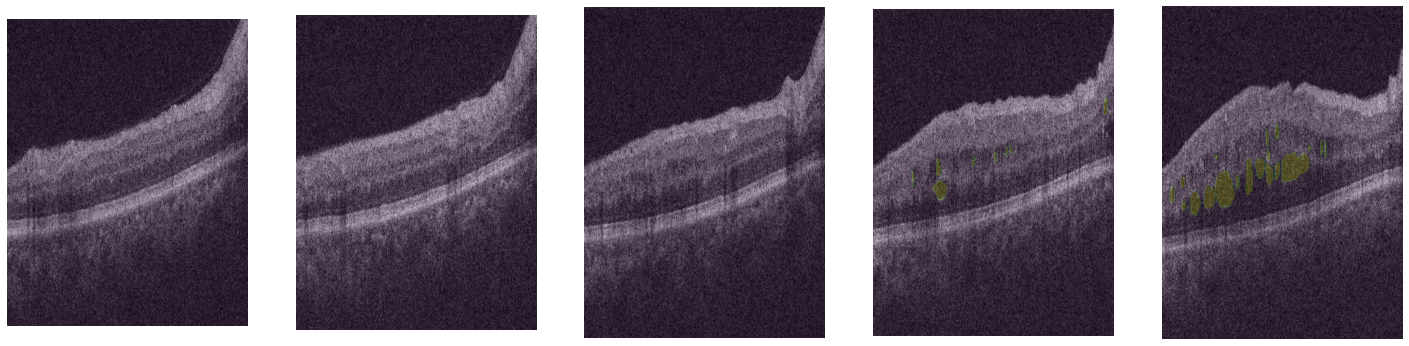

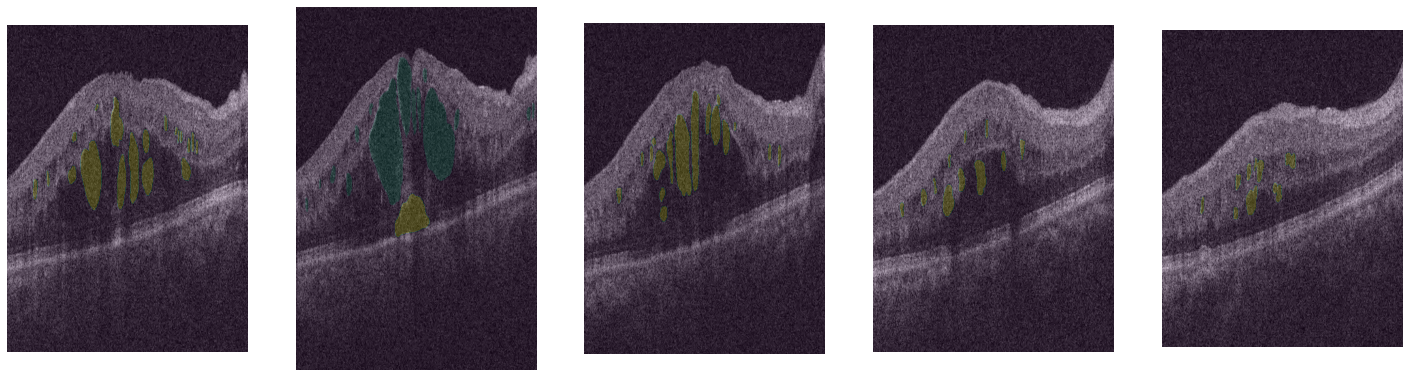

In [513]:
manufacturer = 'Cirrus'
itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-{manufacturer}/TRAIN001/oct.mhd')
ref_itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-{manufacturer}/TRAIN001/reference.mhd')

oct_scan = sitk.GetArrayFromImage(itkimage)
ref_oct_scan = sitk.GetArrayFromImage(ref_itkimage)

plt.figure(figsize=(25,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    im1 = oct_scan[10*i,:,:]
    im2 = ref_oct_scan[10*i,:,:]
    im1, im2 = region_extractor(im1, im2, manufacturer)
    plt.imshow(im1, cmap='gray')
    plt.imshow(im2, alpha=0.2)
    plt.axis('off')
plt.figure(figsize=(25,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    i = i+5
    im1 = oct_scan[10*i,:,:]
    im2 = ref_oct_scan[10*i,:,:]
    im1, im2 = region_extractor(im1, im2, manufacturer)
    plt.imshow(im1, cmap='gray')
    plt.imshow(im2, alpha=0.2)
    plt.axis('off')
plt.show()

In [281]:
def ns_mapper_using_complements(g: np.ndarray, max_iterations: int = 10):
    """
    Obtain the T and I matrices of the image g (one slice of the oct_scan)
    """
    # Step 2
    g_comp = 255 - g
    T = np.zeros(g_comp.shape)
    g_comp_min = np.min(g_comp)
    g_comp_max = np.max(g_comp)
    T = 1 - (g_comp - g_comp_min)/(g_comp_max - g_comp_min)
    
    # Step 3
    kernel = gker2((3,9),1)
    
    # Steps 4,5, 6
    for it in range(max_iterations):
        I = np.zeros((T.shape))
        Ind = np.zeros((T.shape))
        FI = np.zeros((10, T.shape[0], T.shape[1]))
        for j in range(0,10):                                             # Step 5
            rotated_kernel = scipy.ndimage.rotate(kernel, 18*j, reshape=True)   # Step 4
            FI[j,:,:] = cv2.filter2D(T, -1, rotated_kernel)
        T_FI_abs_dif = np.abs(np.repeat(np.expand_dims(T,0),10,0) - FI)
        I = np.min(T_FI_abs_dif, axis=0)                                  # Step 6
        Ind = np.argmax(T_FI_abs_dif, axis=0)

        # Step 7 and 8
        idx = Ind[I >= 0.7]
        T[I >= 0.7] = FI[idx,I >= 0.7]
        
        # Step 9
        entropy = 0 if it==0 else entropy
        entropy_dif = np.abs(scipy.stats.entropy(I.flatten()) - entropy)
        if entropy_dif < 0.001:
            return T, I
        else:
            entropy = scipy.stats.entropy(I.flatten())
    print('Retourned by iterations')
    return T, I

### Comparing both NS mappers 

Si se usa tal cual como está en el paper la imágen que resulta (T_si_comp) no coincide con lo que se muestra

In [282]:
# # Code a function to crop the area of interest in the image.
# g = oct_scan[50,:,:].copy()
# # Get the NS tranform
# T_no_comp, I_no_comp = ns_mapper_no_complements(g, 10)
# T_si_comp, I_si_comp = ns_mapper_using_complements(g, 10)
# T_comp = skimage.util.invert(T_si_comp)

In [283]:
# plt.figure(figsize=(20,10))
# plt.subplot(1,4,1)
# plt.title('Original')
# plt.imshow(g, cmap='gray')
# plt.axis('off')
# plt.subplot(1,4,2)
# plt.title('T_no_comp')
# plt.imshow(T_no_comp, cmap='gray')
# plt.axis('off')
# plt.subplot(1,4,3)
# plt.title('T_si_comp')
# plt.imshow(T_si_comp, cmap='gray')
# plt.axis('off')
# plt.subplot(1,4,4)
# plt.title('T_complemented')
# plt.imshow(T_comp, cmap='gray')
# plt.axis('off')
# plt.show()

La que más se parece a la imagen del paper es la que usa el complemento adentro y complementarlo luego. Ese ultimo paso no aparece en el paper

###  ILM layer and RPE identification functions

In [287]:
def edge_func_ilm(values0, values1, max_g, mean_r, mean_ru, indices0, ilm_image, shape):
#     Pesé el mean_r normalizado para que tenga un peso acorde con los otros
#     grad_weights = (4*max_g - values0 - values1)
#     grad_weights = (grad_weights - grad_weights.min()) / (grad_weights.max() - grad_weights.min())
#     weights = (10*grad_weights + mean_r) * 1e10 + 1e-5
    
    weights = (4*max_g - values0 - values1 + 2*mean_r*max_g + 1e-5)
    w_max = weights.max()
    w_min = weights.min()
    w_range = w_max - w_min
    weights = (weights - w_min) / w_range
    weights = weights * 1e10 + 1e-5
    return weights

def get_ilm_line_paper(g, T, I):
    # Obtain Vertical Gradient Image
    H = np.transpose(np.array([[-2, 0, 2]]))
    VerGrad = scipy.signal.convolve2d(T, H, mode='same', boundary='symm')

    k = 50
    kernel_r = np.ones((k+1,1))/k  # ventana de 40 pixeles arriba de cada nodo
    kernel_r[0] = 0
    R = scipy.signal.convolve2d(g, kernel_r, mode='full', boundary='symm')[:-k,:] #, fillvalue=0)
    R = (R - R.min()) / (R.max() - R.min())
    
    # Padd the image with columns of high values of the gradient so that the weights are low there
    pad_column = np.ones((VerGrad.shape[0],1))
    # Este es el MAXG que mencionan en el paper
    max_T = np.max(T)
    VerGrad = np.concatenate([pad_column*max_T, VerGrad, pad_column*max_T], axis=1)

    # Add very low penalties over the previously added borders in the grad image
    R = np.concatenate([pad_column*0, R, pad_column*0], axis=1)
    # FIND ILM
    # Get the graph from the pixels of the image
    graph_, nodes,_ = pixel_graph(
        VerGrad, edge_function=edge_func_ilm,
        weights_r=R, max_g=max_T, connectivity=2
    )
    graph = nx.from_numpy_array(graph_)
    
    # Find the shortest path using Dijkstra's algorithm
    path = np.array(nx.dijkstra_path(graph, source=0, target=len(nodes)-1, weight='weight'))
    print(nx.shortest_path_length(graph, source=0, target=len(nodes)-1, weight='weight'))
    
    # Generate a binry mask with the line
    ilm_image = np.zeros(VerGrad.shape[0] * VerGrad.shape[1])
    ilm_image[path] = 1
    ilm_image = np.reshape(ilm_image, (VerGrad.shape))
    
    return graph_, R, VerGrad, ilm_image

In [190]:
def edge_func_rpe(values0, values1, max_g, mean_r, mean_u, indices0, ilm_image, shape):
    indices0 = np.array(indices0)
    column_indices = indices0 % ilm_image.shape[0]
    idx = np.zeros(column_indices.shape)
    for i in np.unique(indices0 % ilm_image.shape[0]):
        idx[column_indices==i] = np.max(np.where(ilm_image[:,0]))
    row_ind = indices0 // shape[1]
    D = row_ind - idx
    weights = (2*(4*max_g - values0 - values1) - 2*mean_u*max_g - D*4e-3 + (mean_r*max_g))
    w_max = weights.max()
    w_min = weights.min()
    w_range = w_max - w_min
    weights = (weights - w_min) / w_range
    weights = weights * 1e10 + 1e-5
    return weights #- np.min(weights) +1e5

def get_rpe_line(g, T, I, ilm_image):
    start = time.time()
    # Obtain Vertical Gradient Image
    H = np.transpose(np.array([[2, 0, -2]]))
    VerGrad = scipy.signal.convolve2d(T, H, mode='same', boundary='symm')
    # Padd the image with columns of high values of the gradient so that the weights are low there
    pad_column = np.ones((VerGrad.shape[0],1))
    max_T = np.max(T)
    VerGrad = np.concatenate([pad_column*max_T, VerGrad, pad_column*max_T], axis=1)
    print(f'A: {time.time()-start}')
    
    k = 50
    kernel_r = np.ones((k+1,1))/k  # ventana de 40 pixeles arriba de cada nodo
    kernel_r[0] = 0
    R = scipy.signal.convolve2d(g, kernel_r, mode='full', boundary='symm')[:-k,:] #, fillvalue=0)
    R = 1 - ((R - R.min()) / (R.max() - R.min()))
    R = np.concatenate([pad_column*0, R, pad_column*0], axis=1)
    
    # Obtain the matrix containing all the penalizations to the weights of the image
    k = 10
    kernel_r = np.ones((k+1,1))/k
    kernel_r[-1] = 0
    U = scipy.signal.convolve2d(g, kernel_r, boundary='fill', fillvalue=0)[k:,:]
    U = (U - U.min()) / (U.max() - U.min())
    # Add very low penalties over the previously added borders in the grad image
    U = np.concatenate([pad_column, U, pad_column], axis=1)
    print(f'B: {time.time()-start}')
    
    # FIND ILM
    # Get the graph from the pixels of the image
    graph_, nodes, indices = pixel_graph(
        VerGrad, edge_function=edge_func_rpe, max_g=max_T,
        weights_r=R, weights_u=U, ilm_image=ilm_image, connectivity=2
    )
    print(f'C: {time.time()-start}')
    
    graph = nx.from_numpy_array(graph_)
    print(f'D: {time.time()-start}')
    
    # Find the shortest path using Dijkstra's algorithm
    path = np.array(nx.dijkstra_path(graph, source=0, target=len(nodes)-1, weight='weight'))
    print(f'E: {time.time()-start}')
    
    # Generate a binry mask with the line
    rpe_image = np.zeros(VerGrad.shape[0] * VerGrad.shape[1])
    rpe_image[path] = 1
    rpe_image = np.reshape(rpe_image, (VerGrad.shape))
    return R, graph_, U, VerGrad, rpe_image, indices

In [503]:
def get_retina_mask(ilm_image_fill, rpe_image_fill):
    # ILM mask
    h, w = ilm_image_fill.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)
    ilm_image_fill = ilm_image_fill.astype("uint8")
    cv2.floodFill(ilm_image_fill, mask, (1, 1), 255)
    ilm_image_fill = 1 - ilm_image_fill
    
    # RPE mask
    h, w = rpe_image_fill.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)
    rpe_image_fill = rpe_image_fill.astype("uint8")
    cv2.floodFill(rpe_image_fill, mask, (1, 1), 255)
    rpe_image_fill = 1 - rpe_image_fill
    
    return np.where(ilm_image_fill-rpe_image_fill,1,0)

### Proto pipeline

In [523]:
# Image Loading:
manufacturer = 'Spectralis'
slice_ = 30

itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-{manufacturer}/TRAIN027/oct.mhd')
ref_itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-{manufacturer}/TRAIN027/reference.mhd')

oct_scan = sitk.GetArrayFromImage(itkimage)
ref_oct_scan = sitk.GetArrayFromImage(ref_itkimage)

# Preprocess:
# GUARDAR SIZE Y POSICIONES ORIGINALES PARA RECONSTRUIR TAMAÑO ORIGINAL A LA SALIDA
im, ref = region_extractor(oct_scan[slice_, :, :], ref_oct_scan[slice_, :, :], manufacturer)
if manufacturer=='Spectralis':
    im = cv2.bilateralFilter(src=im, d=10, sigmaColor=200, sigmaSpace=2)
    
# Get the NS tranform
T, I = ns_mapper_using_complements(im, 10)
T = skimage.util.invert(T)

# Get ILM line
_, _, _, ilm_image = get_ilm_line_paper(im, T, I)
# Get RPE line
_, _, _, _, rpe_image, indices = get_rpe_line(im, T, I, ilm_image)

# Get Retina Mask
retina_mask = get_retina_mask(ilm_image, rpe_image)

1775762189484.6377
A: 0.0043239593505859375
B: 0.06944417953491211
C: 0.45472121238708496
D: 22.442177057266235
E: 24.404622554779053


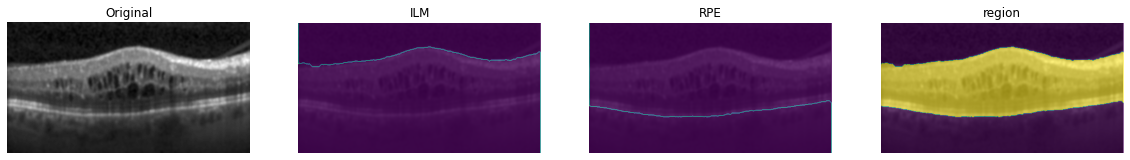

In [524]:
plt.figure(figsize=(20,10))

plt.subplot(1,4,1)
plt.title('Original')
plt.imshow(im, cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.title('ILM')
plt.imshow(im, cmap='gray')
plt.imshow(ilm_image, alpha=0.8)
plt.axis('off')

plt.subplot(1,4,3)
plt.title('RPE')
plt.imshow(im, cmap='gray')
plt.imshow(rpe_image, alpha=0.8)
plt.axis('off')

plt.subplot(1,4,4)
plt.title('region')
plt.imshow(im, cmap='gray')
plt.imshow(retina_mask, alpha=0.6)
plt.axis('off')
plt.show()

In [516]:
# plt.figure(figsize=(20,10))

# plt.subplot(2,4,1)
# plt.title('Original')
# plt.imshow(g, cmap='gray')
# # plt.axis('off')

# plt.subplot(2,4,2)
# plt.title('T')
# plt.imshow(T, cmap='gray')
# plt.axis('off')

# plt.subplot(2,4,3)
# plt.title('I')
# plt.imshow(I, cmap='gray')
# plt.axis('off')

# plt.subplot(2,4,4)
# plt.title('R')
# plt.imshow(R, cmap='gray')
# plt.axis('off')

# plt.subplot(2,4,5)
# plt.title('VerGrad')
# plt.imshow(VerGrad, cmap='gray')
# plt.axis('off')

# plt.subplot(2,4,6)
# plt.title('ILM')
# plt.imshow(g, cmap='gray')
# plt.imshow(ilm_image, alpha=0.8)
# plt.axis('off')

# plt.subplot(2,4,7)
# plt.title('RPE')
# plt.imshow(g, cmap='gray')
# plt.imshow(rpe_image, alpha=0.8)
# plt.axis('off')

# plt.subplot(2,4,8)
# plt.title('region')
# plt.imshow(g, cmap='gray')
# plt.imshow(mask, alpha=0.6)
# plt.axis('off')
# plt.show()

In [517]:
# plt.figure(figsize=(20,10))

# plt.subplot(2,3,1)
# plt.title('Original')
# g = oct_scan[25, 30:-100, :].copy()
# plt.imshow(g, cmap='gray')
# plt.axis('off')

# plt.subplot(2,3,2)
# plt.title('T')
# plt.imshow(T, cmap='gray')
# plt.axis('off')

# plt.subplot(2,3,3)
# plt.title('I')
# plt.imshow(I, cmap='gray')
# plt.axis('off')

# plt.subplot(2,3,4)
# plt.title('R')
# plt.imshow(R, cmap='gray')
# plt.axis('off')

# plt.subplot(2,3,5)
# plt.title('VerGrad')
# plt.imshow(VerGrad, cmap='gray')
# plt.axis('off')

# plt.subplot(2,3,6)
# plt.title('ILM')
# plt.imshow(g, cmap='gray')
# plt.imshow(ilm_image, alpha=0.8)
# plt.axis('off')
# plt.show()

In [518]:
# R, graph_, U, VerGrad, rpe_image, indices = get_rpe_line(g, T, I, ilm_image)

In [519]:
# gim = np.array(np.mean(graph_, axis=1).reshape(VerGrad.shape[0], VerGrad.shape[1]))
# plt.imshow(np.where(gim>2.6e5,1,0))
# plt.axis('off')

In [520]:
# plt.figure(figsize=(20,10))

# plt.subplot(2,3,1)
# plt.title('Original')
# plt.imshow(g, cmap='gray')
# plt.axis('off')

# plt.subplot(2,3,2)
# plt.title('T')
# plt.imshow(T, cmap='gray')
# plt.axis('off')

# plt.subplot(2,3,3)
# plt.title('R')
# plt.imshow(R, cmap='gray')
# plt.axis('off')

# plt.subplot(2,3,4)
# plt.title('U')
# plt.imshow(U, cmap='gray')
# plt.axis('off')

# plt.subplot(2,3,5)
# plt.title('VerGrad')
# plt.imshow(VerGrad, cmap='gray')
# plt.axis('off')

# plt.subplot(2,3,6)
# plt.title('RPE')
# plt.imshow(g, cmap='gray')
# plt.imshow(rpe_image, alpha=0.8)
# plt.axis('off')
# plt.show()

### BACKUP

In [ ]:

# NEUTROSOFIC MAPPER All slices at the same time:
# g = oct_scan.copy()

# # Step 2
# g_comp = 255 - oct_image
# T = np.zeros(g_comp.shape)
# g_comp_min = np.min(np.min(g_comp, axis=2), axis=1)
# g_comp_max = np.max(np.max(g_comp,axis=2), axis=1)
# for i in range(len(g_comp_min)):
#     T[i,:,:] = 1 - (g_comp[i,:,:] - g_comp_min[i])/(g_comp_max[i] - g_comp_min[i])

# # Step 3
# kernel = gker((3,9),1)

# # Steps 4,5, 6
# I = np.zeros((T.shape))
# Ind = np.zeros((T.shape))
# for i in range(T.shape[0]):
#     FI = np.zeros((10, T.shape[1], T.shape[2]))
#     for j in range(0,10):                                             # Step 5
#         rotated_kernel = ndimage.rotate(kernel, 18*j, reshape=True)   # Step 4
#         FI[j,:,:] = cv2.filter2D(T[i,:,:], -1, rotated_kernel)
#     T_FI_abs_dif = np.abs(np.repeat(np.expand_dims(T[i,:,:],0),10,0) - FI)
#     I[j,:,:] = np.min(T_FI_abs_dif, axis=0) # Step 6
#     Ind[j,:,:] = np.max(T_FI_abs_dif, axis=0)

# # Step 7
# T[T >= 0.7] = Ind[T >= 0.7]
# scipy.stats.entropy(I.reshape((I.shape[0], I.shape[1]*I.shape[2])), axis=1)

In [332]:
# def edge_func_ilm(values0, values1, max_g, mean_r, indices0, ilm_image, shape):
#     row_ind = indices0 // shape[1]
#     return 4*max_g - 2*values0 - 2*values1 + 2*mean_r*max_g

# def get_ilm_line_old(g):
#     # Get the NS tranform
#     T, I = ns_mapper(g, 10)
#     T = skimage.util.invert(T)

#     # Obtain Vertical Gradient Image
#     H = np.transpose(np.array([[-2, 0, 2]]))
#     VerGrad = scipy.signal.convolve2d(T, H, 'valid')

#     # Obtain the matrix containing all the penalizations to the weights of the image
#     k = 40
#     kernel_r = np.ones((k+1,1))/k
#     kernel_r[0] = 0
#     # Median filter
# #     print(kernel_r.shape)
# #     g_pad = np.concatenate(
# #         [np.zeros((k+1,g[1:-1,:].shape[1])), g[1:-1,:]],
# #         axis=0
# #     )
# #     R = scipy.signal.medfilt2d(np.abs(g_pad), kernel_size=(41,1))[:-41,:]
#     # Mean filter
# #     R = scipy.signal.convolve2d(g[1:-1,:], kernel_r, boundary='fill', fillvalue=0)[:-k,:]
#     R = scipy.signal.convolve2d(skimage.util.invert(T[1:-1,:]), kernel_r, boundary='fill', fillvalue=0)[:-k,:]
#     R = (R - R.min()) / (R.max() - R.min())
#     print(R.shape)
#     print(VerGrad.shape)
    
#     # Padd the image with columns of high values of the gradient so that the weights are low there
#     pad_column = np.ones((VerGrad.shape[0],1))
#     max_grad = np.max(VerGrad)
#     VerGrad = np.concatenate([pad_column*max_grad, VerGrad, pad_column*max_grad], axis=1)
#     # Add very low penalties over the previously added borders in the grad image
#     R = np.concatenate([pad_column*1e-5, R, pad_column*1e-5], axis=1)

#     # Get the graph from the pixels of the image
#     graph, nodes = pixel_graph(VerGrad, edge_function=edge_func_ilm, max_g=max_grad, weights=, connectivity=2)
#     graph = nx.from_numpy_array(graph)
    
#     # Find the shortest path using Dijkstra's algorithm
#     path = np.array(nx.dijkstra_path(graph, source=0, target=len(nodes)-1, weight='weight'))
# #     nx.shortest_path_length(graph_nx, source=0, target=len(nodes)-1, weight='weight')
    
#     # Generate a binry mask with the line
#     binary_image = np.zeros(VerGrad.shape[0] * VerGrad.shape[1])
#     binary_image[path] = 1
#     bin_image = np.reshape(binary_image, (VerGrad.shape))
    
# #     # Get the coordinates of the line pixels
# #     indices = np.where(bin_image>0)
# #     rest = np.array(list(zip(indices[0], indices[1])))

#     return T, I, R, VerGrad, bin_image